# Import Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA    
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from random import randint
import pickle

## Import data

In [4]:
#drop type column, track_href, key, id, uri, duration_ms, mode, time_signature and analysis url. They have a negative impact on the precision of the model.  
final_p = pd.read_csv('song_recommender_playlist.csv')
final_p = final_p.drop(columns= ["type","track_href","analysis_url", 'key', 'id', 'uri', 'duration_ms','mode', 'time_signature'], axis=1)
final_p = final_p.dropna(subset = ['danceability', 'artist'])
final_p

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.7760,-5.874,0.0356,0.01840,0.002940,0.1280,0.703,130.128
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.4040,-9.928,0.0499,0.27100,0.000000,0.3000,0.224,71.105
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.5280,-6.472,0.1610,0.11200,0.312000,0.1630,0.754,109.967
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.8680,-5.276,0.1700,0.04750,0.000176,0.7760,0.609,156.295
4,Queen,Under Pressure - Remastered 2011,0.671,0.7120,-7.815,0.0476,0.42900,0.000000,0.1030,0.462,113.805
...,...,...,...,...,...,...,...,...,...,...,...
12603,Fleetwood Mac,Mystified,0.533,0.2510,-18.749,0.0275,0.73100,0.173000,0.0917,0.582,177.957
12604,Fleetwood Mac,Welcome To The Room...Sara,0.632,0.5550,-13.081,0.0409,0.11400,0.000003,0.2600,0.732,99.064
12605,Fleetwood Mac,Isn't It Midnight,0.469,0.7300,-11.890,0.0358,0.00264,0.048200,0.1500,0.573,145.781
12606,Fleetwood Mac,When I See You Again,0.544,0.0907,-20.015,0.0268,0.87200,0.000000,0.1030,0.103,79.789


## Xy Split

This is not a necessary step in clustering, but we will require an output in the recommender. 

In [5]:
X = final_p.select_dtypes(include=np.number)
y = final_p[['song','artist']]

**We have now isolated the features, and will scale them**

In [7]:
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.670,0.776,-5.874,0.0356,0.0184,0.002940,0.128,0.703,130.128
1,0.414,0.404,-9.928,0.0499,0.2710,0.000000,0.300,0.224,71.105
2,0.933,0.528,-6.472,0.1610,0.1120,0.312000,0.163,0.754,109.967
3,0.559,0.868,-5.276,0.1700,0.0475,0.000176,0.776,0.609,156.295
4,0.671,0.712,-7.815,0.0476,0.4290,0.000000,0.103,0.462,113.805


Scaling the features

In [10]:
scaler = StandardScaler()

X_scaler = scaler.fit(X)
X_prep = X_scaler.transform(X)

In [11]:
pd.DataFrame(X_prep,columns=X.columns).head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.799831,0.389792,0.580265,-0.441994,-0.751429,-0.444342,-0.428415,0.807231,0.320009
1,-0.729553,-1.199113,-0.488768,-0.263079,0.127655,-0.455817,0.601773,-1.111861,-1.776086
2,2.371035,-0.669478,0.422573,1.126955,-0.425688,0.761951,-0.218784,1.011561,-0.395973
3,0.136700,0.782747,0.737956,1.239560,-0.650157,-0.455130,3.452758,0.430624,1.249282
4,0.805806,0.116432,0.068426,-0.291855,0.677518,-0.455817,-0.578152,-0.158325,-0.259673


## Determining number of Clusters

### We have used PCA to determine the amount of clusters which will be required. 

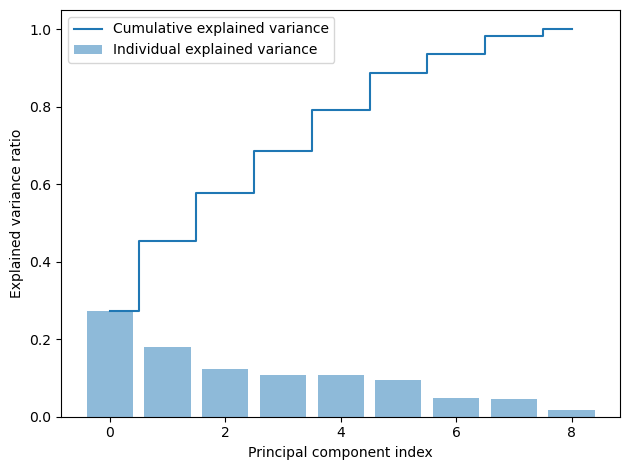

In [12]:
pca = PCA()
pca.fit(X_prep)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

So far, it looks like 8 clusters may be necessary. 

In [20]:
pca = PCA(8)
pca.fit(X_prep)

PCA(n_components=8)

In [14]:
pca.explained_variance_ratio_.sum()

0.9816063908944237

**Here we can see that using 8 clusters for the songs would account for 98% of the features** 

**Although 8 seems like the right number of clusters, we do have a high number of songs, and only splitting them into 8 different groupings may affect the accuracy of the recommender. We will check to see if there is a higher desired value by using the elbow method**

## Elbow Method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

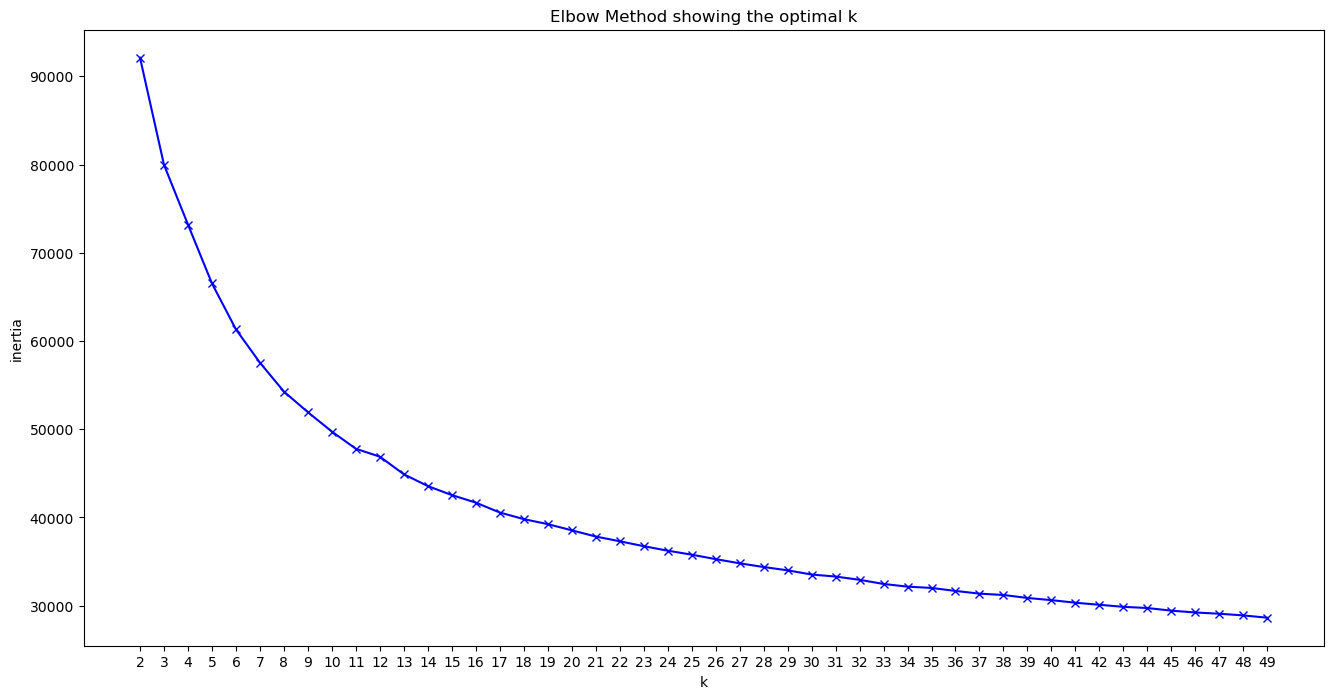

In [23]:
K = range(2, 50)
inertia = []

for k in K:
    kmeans1 = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans1.fit(X_prep)
    inertia.append(kmeans1.inertia_)

    
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Here we have expanded the potential number of clusters to 50 in order to see whether there is much opportunity for a higher number of clusters in order to make our recommendations as accurate as poçssible. 

## Fitting our Model

**After performing a primary component analysis (pca) on our data, we have decided on 16 clusters, and will fit our model accordingly**

In [44]:
kmeans = KMeans(n_clusters=16, random_state=1234)
KM = kmeans.fit(X_prep)
KM

KMeans(n_clusters=16, random_state=1234)

In [37]:
#We can check our cluster sizes
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0      672
1      765
2     1497
3     1515
4      656
5      300
6      569
7       57
8      629
9      426
10     582
11    1250
12    1070
13    1031
14     954
15     622
Name: count, dtype: int64

In [42]:
#assign the clusters to the dataframe. 
final_p['cluster'] = clusters
final_p['cluster'].unique()

array([ 3,  1,  8, 12, 14, 11, 10, 13,  2,  4,  9,  6, 15,  5,  0,  7],
      dtype=int32)

In [41]:
final_p.head()

,artist,song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Queen,A Kind Of Magic - Remastered 2011,0.670,0.776,-5.874,0.0356,0.0184,0.002940,0.128,0.703,130.128,3
1,Queen,Bohemian Rhapsody - Remastered 2011,0.414,0.404,-9.928,0.0499,0.2710,0.000000,0.300,0.224,71.105,1
2,Queen,Another One Bites The Dust - Remastered 2011,0.933,0.528,-6.472,0.1610,0.1120,0.312000,0.163,0.754,109.967,3
3,Queen,Don't Stop Me Now - Remastered 2011,0.559,0.868,-5.276,0.1700,0.0475,0.000176,0.776,0.609,156.295,8
4,Queen,Under Pressure - Remastered 2011,0.671,0.712,-7.815,0.0476,0.4290,0.000000,0.103,0.462,113.805,12


We can see above that the "cluster" column now contains different numbers, which will determine the groups in our model. 

## Export the clustered dataframe to a csv. 

In [43]:
final_p.to_csv('spotify_songs_clusters.csv',index = False)

## Pickling models for future use in the song recommender algorithm

Pickle Kmeans

In [47]:
#Saving the model to a file using pickle

pickle.dump(KM, open('models_scalers/kmeans.pkl','wb'))

Pickle Scaler

In [48]:
#Saving the model to a file using pickle

pickle.dump(X_scaler, open('models_scalers/scaler.pkl','wb'))